In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import pymc as pm
import arviz as az
import seaborn as sns
import itertools
import cloudpickle

from scipy.special import logit, expit
from scipy.stats import bernoulli, norm, t, skewnorm
from matplotlib import pyplot as plt
from time import time

from modeltools import plot_prior_postrr, create_summary_stat, mcmc_diagnostics 
from downcast import downcast_df

In [2]:
#  Setting up seeds
seed = 42

# Setting numpy seed
np.random.seed(seed)

In [3]:
raw_data = pd.read_csv("data/unit_level_ratings.csv",index_col = 0)
raw_data = raw_data.sort_values(by=["corpus", "model", "topic"])

In [4]:
# Creating identifier for each corpus, model, and topic
# Identifier is unique for topic 
corpus_ids = (raw_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (raw_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (raw_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

topic_ids = (raw_data.groupby(["corpus", "model", "topic"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
topic_ids["topic_id"] = topic_ids["topic"].astype(np.int16)

rater_ids = (raw_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 


d1 = pd.merge(raw_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

In [5]:
# Setting up numpy arrays for pymc
corpus_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

model_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordel_array = np.array(data["cordel_id"])
n_cordels = data["cordel_id"].nunique()

topic_array = np.array([data["cordel_id"], data["topic_id"]])
n_topics = data["topic_id"].nunique()

rater_array = np.array(data["rater_id"])
n_raters = data["rater_id"].nunique()

score_array = np.array(data["intrusion"])

## Comparing model with/without cordel mean

In [6]:
# Model and MCMC specifications

n_cores = 2
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1

In [7]:
# Collection of model, trace, prior & posterior simulations
# {"model": pm.Model, 
#  "trace": az.InferenceData, 
#  "prior_sim": az.InferenceData, 
#  "postrr_sim": az.InferenceData}

glm_rater_topic = {"model":pm.Model()}
glm_rater_topic_cordel = {"model":pm.Model()}


In [8]:
# Rater, Topic, Cordel model

glm_rater_topic_cordel["model"] = pm.Model()
with glm_rater_topic_cordel["model"]:
    # Hyperparameter priors
    raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")
    
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu[cordels]+
                za[topics[0],topics[1]]*sigma_a+
                zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
                              dims="obs_id")
    
    glm_rater_topic_cordel["trace"]=pm.sample(cores=n_cores, random_seed = seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 267 seconds.


## Diagnostics

In [9]:
glm = glm_rater_topic_cordel
glm

{'model': sigma_r ~ Exp(f())
      zr ~ N(0, 1)
 sigma_a ~ Exp(f())
      za ~ N(0, 1)
      mu ~ N(1.1, 1)
  c_mean ~ Deterministic(f(mu, sigma_a, za))
       s ~ Bern(f(sigma_r, zr, mu, sigma_a, za)),
 'trace': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data
 	> constant_data}

In [10]:
summary_stat = create_summary_stat(glm["trace"])

In [11]:
summary_stat

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,zr,0,0.6806,0.6487,-0.5654,1.8940,0.0099,0.0108,4261.4724,1196.1210,1.0005
1,zr,1,0.7432,0.6368,-0.4464,1.9121,0.0100,0.0105,3956.4506,1390.7791,1.0002
2,zr,2,-0.3969,0.6752,-1.6925,0.8317,0.0098,0.0147,4793.5753,1377.3208,1.0032
3,zr,3,0.0926,0.6647,-1.1186,1.2876,0.0096,0.0203,4819.0823,1410.8803,1.0018
4,zr,4,0.3085,0.6577,-0.9715,1.4824,0.0110,0.0156,3556.2196,884.2577,1.0056
...,...,...,...,...,...,...,...,...,...,...,...
630,c_mean,1,0.6405,0.0118,0.6173,0.6622,0.0003,0.0002,1971.9636,1659.9829,1.0009
631,c_mean,2,0.7151,0.0110,0.6954,0.7359,0.0003,0.0002,1775.5181,1939.0901,1.0004
632,c_mean,3,0.7581,0.0107,0.7396,0.7798,0.0002,0.0002,2001.3078,1767.1986,1.0017
633,c_mean,4,0.7011,0.0112,0.6791,0.7204,0.0003,0.0002,1984.7820,1607.4052,0.9996


In [12]:
# mcmc_diagnostics(glm["trace"], summary_stat)

## Checking topic distributions

In [17]:
summary_stat_cordel=create_summary_stat(glm_rater_topic_cordel["trace"])

## Simulating Rater/Topic Interactions

In [18]:
p_diff = 0.08
n_sim_raters = 40
topics_per_r = 40
n_sims = 1_000

# Reset np seed to be same as script
np.random.seed(seed)

# Adding cordel id to topic_ids dataframe
topic_cordel_ids = pd.merge(topic_ids, cordel_ids, on=["corpus", "model"], how="left")

In [19]:
def resample(all_ids, param, size, bound=0.1):
    # resampling raters and topics such that effects sum to 0.

    s = summary_stat_cordel[summary_stat_cordel["param"]==param].copy(deep=True)

    if param == "za":
        s[["a", "b"]] = s["param_num"].str.split(", ", expand=True)
        s["param_num"] = (s["a"].astype(int)*50 + s["b"].astype(int)).astype(str)

    mean_sum = 9999
    while mean_sum < -bound or mean_sum > bound:
        ids = np.random.choice(all_ids, size=size, replace=True)
        mean_sum = sum([s[(s["param_num"]==str(i))]["mean"].item() for i in ids])
    
    return ids

In [20]:
ps_data = pd.DataFrame(columns=["sim_id", "sim_cordel_id", "sim_topic_id", "sim_rater_id", 
                                "cordel_id", "topic_id", "rater_id"], dtype=np.int16)
start = time()

for sim_id in range(n_sims):

    # data template
    sim_data = pd.DataFrame(columns=["sim_id", "cordel_id", "topic_id", "rater_id"])  
    
    # Raters in this simulation
    raters = resample(data["rater_id"].unique(), param="zr", size=n_sim_raters, bound=1)

    
    # Topics in this simulation (topic_cordel_ids index values)
    sim_topics_0 = resample(range(len(topic_cordel_ids)), param="za", size=50, bound=1)
    sim_topics_1 = resample(range(len(topic_cordel_ids)), param="za", size=50, bound=1)
    sim_topics = np.concatenate((sim_topics_0, sim_topics_1))

    # Count of scores for each topic
    counts = np.zeros(100)

    for sim_rater_id, rater in enumerate(raters):
    #     Set the probability. Topics with fewer samples have higher probability
        counts = counts-counts.min()+1
        p = 1/counts**20
        p = p/p.sum()

    #     Sample according to probability
        rated_topics = np.random.choice(range(100), size=topics_per_r, replace=False, p=p)
        rated_topics_idx = sim_topics[rated_topics]
        counts[rated_topics] += 1

    #     Append topics to simulation
        d=topic_cordel_ids.loc[rated_topics_idx, ["topic_id", "cordel_id"]]
        d["sim_rater_id"]=sim_rater_id
        d["sim_topic_id"]=rated_topics
        d["rater_id"]=rater

        sim_data = pd.concat([sim_data, d], axis="rows", ignore_index=True)

#     Adding one topic/rater interaction into df
    sim_data["sim_id"] = sim_id
    sim_data.loc[sim_data["sim_topic_id"].isin(range(0,50)),["sim_cordel_id"]] = 0
    sim_data.loc[sim_data["sim_topic_id"].isin(range(50,100)),["sim_cordel_id"]] = 1
#     sim_data = pd.merge(sim_data, topic_counts[["cordel_id", "topic_id", "sim_cordel_id"]]
#                         ,on=["cordel_id", "topic_id"], how="left")
    sim_data=sim_data.astype(np.int16)

#     Appending interaction to ds.
    ps_data = pd.concat([ps_data, sim_data], ignore_index=True)
    
    if sim_id % 100 == 0:
        print(f"sim_id {sim_id}: {time() - start:.2f}s")

sim_id 0: 0.48s
sim_id 100: 58.78s
sim_id 200: 114.40s
sim_id 300: 172.97s
sim_id 400: 219.06s
sim_id 500: 273.61s
sim_id 600: 327.14s
sim_id 700: 375.44s
sim_id 800: 433.81s
sim_id 900: 494.00s


In [22]:
d = ps_data.copy(deep=True)

[]

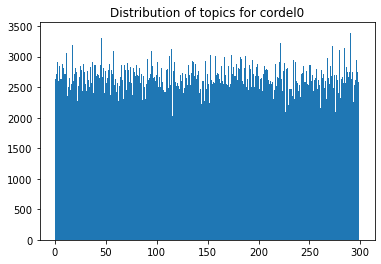

In [23]:
d["topic_idx"] = d["cordel_id"]*np.array([50]) + d["topic_id"]
plt.hist(d[d["sim_cordel_id"]==0]["topic_idx"], bins=300)
plt.title("Distribution of topics for cordel0")
plt.plot()

[]

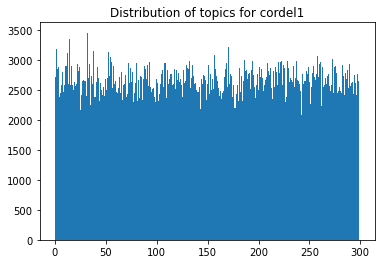

In [24]:
d["topic_idx"] = d["cordel_id"]*np.array([50]) + d["topic_id"]
plt.hist(d[d["sim_cordel_id"]==1]["topic_idx"], bins=300)
plt.title("Distribution of topics for cordel1")
plt.plot()

[]

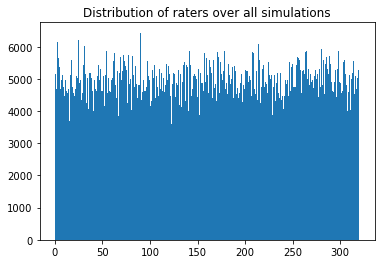

In [25]:
plt.hist(d["rater_id"], bins=d["rater_id"].nunique())
plt.title("Distribution of raters over all simulations")
plt.plot()

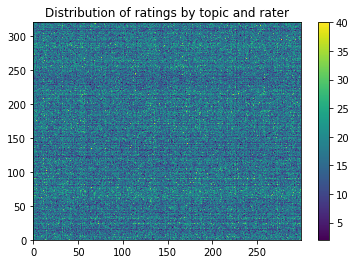

In [26]:
fig, ax = plt.subplots()
hh = ax.hist2d(d["topic_idx"], d["rater_id"],bins=[300, d["rater_id"].nunique()])
fig.colorbar(hh[3], ax=ax)
plt.title("Distribution of ratings by topic and rater")
plt.show()

## Simulating Scores

In [21]:
pymc_model = glm_rater_topic_cordel["model"]
trace = glm_rater_topic_cordel["trace"]

# Calculating proposed logodds means
# https://www.wolframalpha.com/input?i=solve+for+x+and+y%2C+x%2By%3Dc%2C+1%2F%281%2Be%5E-x%29-1%2F%281%2Be%5E-y%29%3Dp
mean_model_logodds = summary_stat[summary_stat["param"]=="mu"]["mean"].mean()
c = 2*mean_model_logodds
C = np.exp(-c)
det = p_diff**2-2*C*(p_diff**2-2)+(C**2)*(p_diff**2)
quad = (-p_diff*(C+1)+det**0.5)/(2*(p_diff+1))
proposed_model1_mean = -np.log(quad)
proposed_model0_mean = c-proposed_model1_mean

In [22]:
# Setting trace of cordel 0 and cordel 1 to proposed values
trace.posterior["mu"].loc[dict(mu_dim_0=0)] = proposed_model0_mean
trace.posterior["mu"].loc[dict(mu_dim_0=1)] = proposed_model1_mean

In [23]:
start = time()

sim_scores = pd.DataFrame(columns=["sim_id", "sim_cordel_id", "sim_topic_id", "sim_rater_id", "cordel_id", "topic_id", "rater_id", "intrusion", ]
                       ,dtype=np.int16)
# TODO: add chain options
for sim_id in range(1_000):
    # Setting data containing rater/topic interaction
    sim_data = ps_data[ps_data["sim_id"]==sim_id]
    sim_rater_array = np.array(sim_data["rater_id"], dtype=int)
    topic_array = np.array([sim_data["cordel_id"], sim_data["topic_id"]], dtype=int)
    cordel_array = np.array(sim_data["sim_cordel_id"], dtype=int)
    
    # Running simulation
    with pymc_model:
        pm.set_data({
            "raters":sim_rater_array, 
            "topics":topic_array, 
            "cordels":cordel_array})
        postrr_sim=pm.sample_posterior_predictive(trace.posterior.sel({"chain":[0], "draw":[sim_id]})
                                                  ,predictions=True, progressbar=False, random_seed=seed+sim_id)
    
    # Adding results to sim_scores
    s = (postrr_sim.predictions.to_dataframe().reset_index()
          .rename(columns={"s":"intrusion"}))
    this_sim_scores = pd.concat([sim_data.reset_index(drop=True)
                                 ,s["intrusion"]], axis="columns").astype(np.int16)
    sim_scores = pd.concat([sim_scores, this_sim_scores], axis="index", ignore_index=True)
    
    if sim_id % 100 == 0:
        print(f"sim_id {sim_id}: {time() - start:.2f}s")
print(f"done! {time() - start:.2f}s")

sim_id 0: 0.13s
sim_id 100: 10.46s
sim_id 200: 19.38s
sim_id 300: 27.99s
sim_id 400: 35.63s
sim_id 500: 43.03s
sim_id 600: 50.65s
sim_id 700: 58.36s
sim_id 800: 67.14s
sim_id 900: 76.76s
done! 84.91s


Perc of simulations with mean1 < mean0 (n raters=40): 0.2%


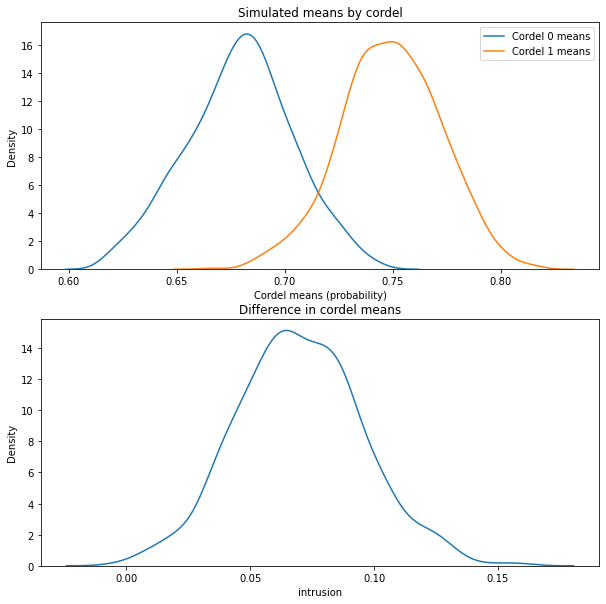

In [24]:
_, ax = plt.subplots(2,1,figsize=(10,10))

n_ratings_per_cordel = n_sim_raters*topics_per_r/2

sns.kdeplot(sim_scores[sim_scores["sim_cordel_id"]==0].groupby(["sim_id"]).agg({"intrusion":"sum"})["intrusion"]/n_ratings_per_cordel, ax=ax[0])
sns.kdeplot(sim_scores[sim_scores["sim_cordel_id"]==1].groupby(["sim_id"]).agg({"intrusion":"sum"})["intrusion"]/n_ratings_per_cordel, ax=ax[0])
ax[0].legend(ax[0].get_lines(), ["Cordel 0 means", "Cordel 1 means"])
ax[0].set_xlabel("Cordel means (probability)")
ax[0].set_title(f"Simulated means by cordel")

diff = sim_scores[sim_scores["sim_cordel_id"]==1].groupby(["sim_id"]).agg({"intrusion":"sum"}) \
        - sim_scores[sim_scores["sim_cordel_id"]==0].groupby(["sim_id"]).agg({"intrusion":"sum"})

sns.kdeplot(diff["intrusion"]/n_ratings_per_cordel, ax=ax[1])
ax[1].set_title(f"Difference in cordel means")
plt.plot()

print(f"Perc of simulations with mean1 < mean0 (n raters={n_sim_raters}): {(diff['intrusion']<=0).sum()/1000:.1%}")


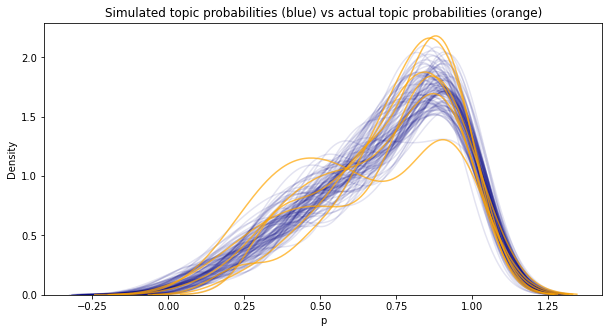

In [25]:
size=100

_, ax = plt.subplots(1,1,figsize=(10,5))


# Selecting 100 random simulations
rand_ids = np.random.choice(range(1000), size=size, replace=False)

# Calculating topic proportions
samples = (sim_scores[sim_scores["sim_id"].isin(rand_ids)].groupby(["sim_id", "sim_topic_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
samples["p"] = samples[("intrusion", "sum")]/samples[("intrusion", "count")]

# Plotting proportions
for sim_id in rand_ids:
    sns.kdeplot(samples[samples["sim_id"]==sim_id]["p"], ax=ax, color="navy", alpha=7/size**0.9)

# Repeat calculations and plots for actual data
actuals = (data.groupby(["cordel_id", "topic_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
actuals["p"]=actuals[("intrusion", "sum")]/actuals[("intrusion", "count")]
for cordel_id in range(6):
    sns.kdeplot(actuals[actuals["cordel_id"]==cordel_id]["p"], ax=ax, color="orange", alpha=0.7)

ax.set_title("Simulated topic probabilities (blue) vs actual topic probabilities (orange)")
plt.show()

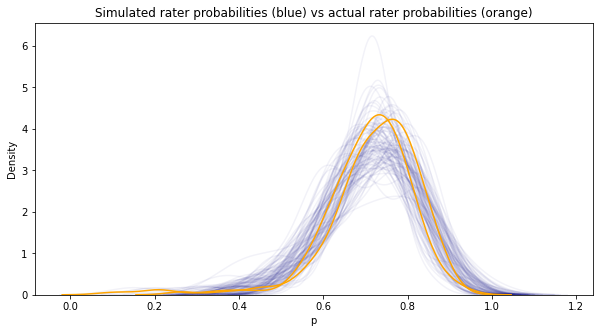

In [26]:
size=100

_, ax = plt.subplots(1,1,figsize=(10,5))


# Selecting 100 random simulations
rand_ids = np.random.choice(range(1000), size=size, replace=False)

# Calculating rater proportions
samples = (sim_scores[sim_scores["sim_id"].isin(rand_ids)].groupby(["sim_id", "sim_rater_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
samples["p"] = samples[("intrusion", "sum")]/samples[("intrusion", "count")]
# Plotting proportions
for sim_id in rand_ids:
    sns.kdeplot(samples[samples["sim_id"]==sim_id]["p"], ax=ax, color="navy", alpha=0.05)

# Repeat calculations and plots for actual data
actuals = (data.groupby(["corpus_id", "rater_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
actuals["p"]=actuals[("intrusion", "sum")]/actuals[("intrusion", "count")]
for corpus_id in range(2):
    sns.kdeplot(actuals[actuals["corpus_id"]==corpus_id]["p"], ax=ax, color="orange", alpha=1)

ax.set_title("Simulated rater probabilities (blue) vs actual rater probabilities (orange)")
plt.show()

## Checking saved model

In [3]:
with open("bayesian_model/glmm.pickle", "rb") as f:
    inferred_glmm = cloudpickle.load(f)

In [6]:
s=inferred_glmm["summary_stat"]

In [7]:
# Fortunately the infered model does not run into phantom topic issue.
s[s["param"]=="za"]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
321,za,"0, 0",-1.1357,0.2887,-1.6494,-0.5442,0.0212,0.0150,185.8798,555.2656,NaN
322,za,"0, 1",-0.1367,0.3716,-0.8340,0.5077,0.0225,0.0159,272.9664,516.4476,NaN
323,za,"0, 2",0.2953,0.3248,-0.2933,0.9033,0.0192,0.0137,296.8024,495.7466,NaN
324,za,"0, 3",1.1639,0.4572,0.4052,2.0516,0.0199,0.0141,529.0294,502.3017,NaN
325,za,"0, 4",-0.1818,0.3036,-0.7903,0.3374,0.0193,0.0137,247.5332,609.4406,NaN
...,...,...,...,...,...,...,...,...,...,...,...
616,za,"5, 45",-0.8146,0.2770,-1.3137,-0.2959,0.0155,0.0111,326.1145,538.7747,NaN
617,za,"5, 46",-0.6670,0.3074,-1.2094,-0.0587,0.0172,0.0121,322.8708,410.4931,NaN
618,za,"5, 47",-0.7286,0.2738,-1.2181,-0.1968,0.0164,0.0116,276.0288,471.7395,NaN
619,za,"5, 48",0.2532,0.3406,-0.4513,0.8043,0.0179,0.0135,378.7252,467.7994,NaN
